In [1]:
import argparse
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math
from IPython.display import display
from multiprocessing import cpu_count,Pool 
from joblib import Parallel, delayed
import psutil
import multiprocessing
import time

In [2]:
def print_memory_usage():
    print ("memory log:")
    process = psutil.Process(os.getpid())
    print("%5.2f GB (RSS)" % (process.memory_info().rss / 2**30))
    print("%5.2f GB (VMS)" % (process.memory_info().vms / 2**30))
    print("%5.2f GB (Used)" % (psutil.virtual_memory().used / 2**30))
    print("%5.2f GB (Available)" % (psutil.virtual_memory().available / 2**30))
    print("%5.2f GB (Total)" % (psutil.virtual_memory().total / 2**30))
    
class WithExtraArgs(object):
    def __init__(self, func, **args):
        self.func = func
        self.args = args
    def __call__(self, df):
        return self.func(df, **self.args)
def applyParallel_list(pool,data, func, kwargs):
    data_split = np.array_split(data,partitions)
    data =pool.map(WithExtraArgs(func, **kwargs), data_split)
    return data

In [3]:
cores = cpu_count() #Number of CPU cores on your system
partitions = cores #Define as many partitions as you want
print ("number of cores "+str(partitions))

sample_rate = 1
raduis = 14 # mi

#effective_days=300
#max_effective_days = 15*24*60

number of cores 28


In [4]:
print("Load long events")
long_events_ = pd.read_hdf('../long_events_.h5',key='LN_300_nc2')
print ("*"*80)
print (long_events_.shape)
long_events_.duration.max()

Load long events
********************************************************************************
(148237, 18)


52435.01666666667

In [5]:
import pickle
with open("test.txt", "rb") as fp:
    final_data_frame = pickle.load(fp)

In [6]:
len(final_data_frame)

148237

# filter events with zero

In [7]:

file = "AirportWithNoTrafficDataBefore25July2017.txt"
airport_lists = pd.read_csv(file,low_memory=True)
#airport_lists.head()
mask_arr=[]
time = pd.to_datetime("2017-07-25 00:00:00", format="%Y-%m-%d %H:%M:%S", errors='coerce')
#print (time)
#counter=0
for idx,long_event in long_events_.iterrows():
    #print (idx)
    if long_event.Type == 'W' and (long_event.AirportCode in airport_lists.Airports.values )and long_event.EndTime < time:
        mask_arr.append(0)
    else:
        mask_arr.append(1)
#print (counter)
print (len(mask_arr))

148237


In [8]:
print("check significance of events in long event period")
def parjob_significance(group_frame):
    ret_list=[]
    counter=0
    size = len(group_frame.groups.items())
    for key, value in group_frame.groups.items():    
        city_values_out=[]
        city_values_in=[]
        
        counter+=1
        if counter%1000==0:
            print(counter,"/",size," group processed")
        for idx in value:
            relation_idx = long_events_.index.get_loc(idx)
            if mask_arr[relation_idx] == 1:
                city_values_out.append(final_data_frame[relation_idx].Mean.sum())
                city_values_in.append(final_data_frame[relation_idx].During.sum())

        #city_values_out = [0 if x != x else x for x in city_values_out]
        #city_values_in = [0 if x != x else x for x in city_values_in]
        out_arr = np.array(city_values_out)
        in_arr = np.array(city_values_in)
        deduct = in_arr-out_arr
        over_zero = deduct [np.where( deduct > 0 )].shape[0]
        under_zero = deduct[np.where(deduct<0)].shape[0]
        zero = deduct[np.where(deduct==0)].shape[0]
        total = deduct.shape[0]
        try:
            percentage_over  = float(over_zero)/total
            percentage_under = float(under_zero)/total
            percentage_zero = float(zero)/total                                    
        except ZeroDivisionError as err:
            print (err)
            percentage_over  = 0
            percentage_under = 0
            percentage_zero = 0
        #return percentage_over,percentage_under
        ret_list.append([percentage_over,percentage_under,percentage_zero])
    return ret_list

check significance of events in long event period


In [9]:
def plot_hist(data,title="No Title", ylabel="No Y lable", xlabel="No X label",plot_type='normal'):
    plt.figure()
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if plot_type=='normal':
        plt.hist(data)
    else:
        plt.hist(np.log(data))
    plt.show()

In [10]:
localize_events_traffic = long_events_.groupby(['State'])
percentage_values_over=parjob_significance(localize_events_traffic)
per_arr_city_base = np.array(percentage_values_over)

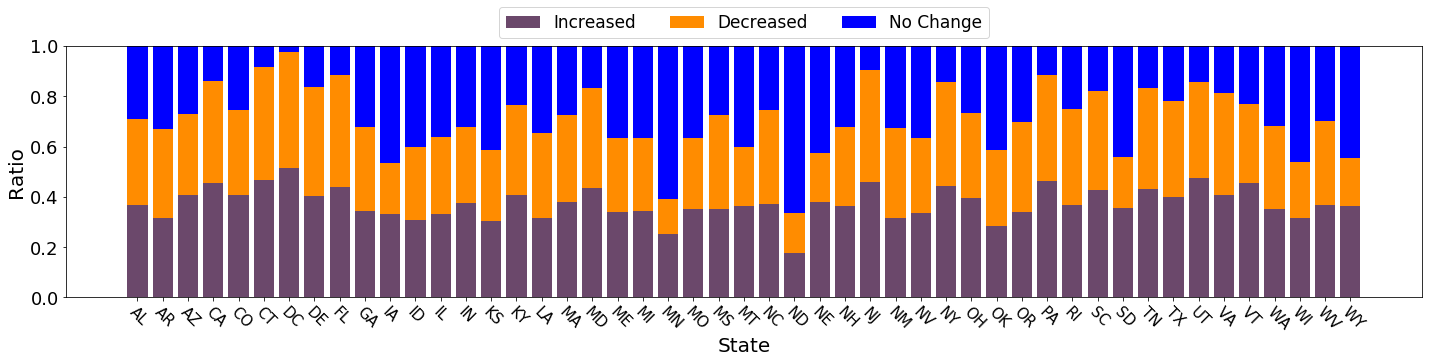

********************************************************************************


In [11]:
plt.figure()
# create plot
fig, ax = plt.subplots(figsize=(20,4.7))
objects=localize_events_traffic.groups.keys()
index = np.arange(len(objects))
bar_width = 0.8
opacity = 1
 
rects1 = plt.bar(index, per_arr_city_base[:,0], bar_width,
                 #alpha=opacity,
                 color='#6b486b',
                 label='Increased')
rects2 = plt.bar(index, per_arr_city_base[:,1], bar_width,
                 #alpha=opacity,
                 color='#ff8c00',
                 label='Decreased',
                bottom=per_arr_city_base[:,0])
rects3 = plt.bar(index, per_arr_city_base[:,2], bar_width,
                 #alpha=opacity,
                 color='b',
                 label='No Change',
                bottom=per_arr_city_base[:,0]+per_arr_city_base[:,1])

plt.xlabel('State',size=20)
plt.ylabel('Ratio',size=20)
#plt.title('Increase/decrease traffic events during long event for different State/Cities')
plt.xticks(index, objects,rotation=-45,ha="left", rotation_mode="anchor",size=15)
plt.yticks(size=18)
plt.ylim((0.0, 1.0))
plt.legend(loc="upper center",ncol=3,prop={'size': 17},bbox_to_anchor=(0.5, 1.19))
 
plt.tight_layout()
fig.savefig("over_under.pdf", format='pdf',bbox_inches='tight')
plt.show()
print ("*"*80)

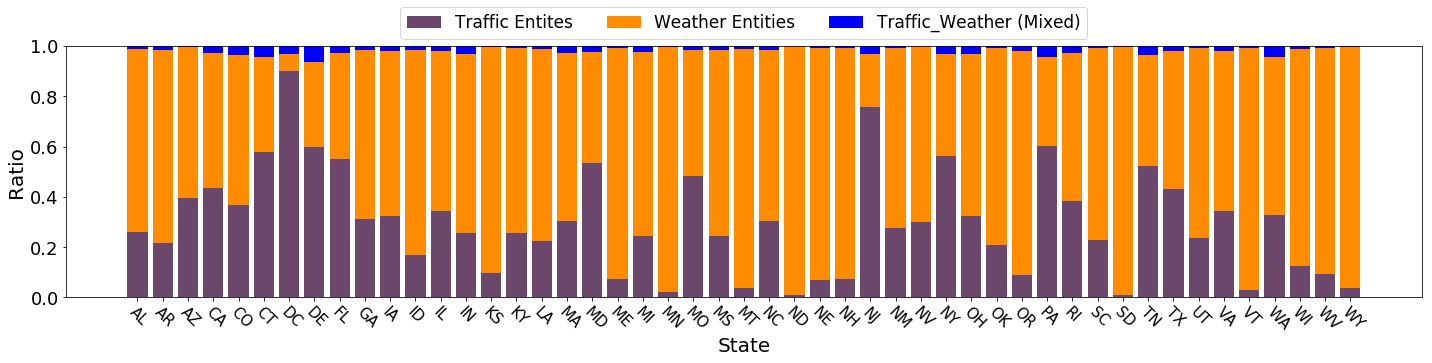

********************************************************************************


In [12]:
localize_event_ratio = long_events_.groupby(['State','Type']).size().to_frame('count').reset_index().pivot(index="State",columns="Type",values='count')
localize_event_ratio= localize_event_ratio.fillna(0)
localize_event_ratio['total'] =  localize_event_ratio.T_W+localize_event_ratio['T']+localize_event_ratio.W
localize_event_ratio['t_w_rat'] = localize_event_ratio.T_W/localize_event_ratio.total
localize_event_ratio['t_ra'] = localize_event_ratio['T']/localize_event_ratio.total
localize_event_ratio['w_ra'] = localize_event_ratio.W/localize_event_ratio.total
#display(localize_event_ratio)
plt.figure()
# create plot
fig, ax = plt.subplots(figsize=(20,4.7))
objects=localize_events_traffic.groups.keys()
index = np.arange(len(objects))
bar_width = 0.8
opacity = 1
 
rects1 = plt.bar(index, localize_event_ratio.t_ra, bar_width,
                 #alpha=opacity,
                 color='#6b486b',
                 label='Traffic Entites')
rects2 = plt.bar(index, localize_event_ratio.w_ra, bar_width,
                 #alpha=opacity,
                 color='#ff8c00',
                 label='Weather Entities',
                bottom=localize_event_ratio.t_ra)
rects3 = plt.bar(index, localize_event_ratio.t_w_rat, bar_width,
                 #alpha=opacity,
                 color='b',
                 label='Traffic_Weather (Mixed)',
                bottom=localize_event_ratio.w_ra+localize_event_ratio.t_ra)
plt.xlabel('State',size=20)
plt.ylabel('Ratio',size=20)
#plt.title('Increase/decrease traffic events during long event for different State/Cities')
plt.xticks(index, objects,rotation=-45,ha="left", rotation_mode="anchor",size=15)
plt.yticks(size=18)
plt.legend(loc="upper center",ncol=3,prop={'size': 17},bbox_to_anchor=(0.5, 1.19))

plt.tight_layout()
fig.savefig("weather-trafic.pdf", format='pdf',bbox_inches='tight')
plt.show()
print ("*"*80)


In [11]:
import scipy.stats

print ("check significance by test T-TEST")
def compute_pvalue_two_sided(localize_events_traffic,column,min_sample):
    Dif = 0# 5, 10, 15, 20, ...
    sig_level=0.01#0.05,0.10, 0.2, ...
    import scipy.stats
    p_values2=[]
    p_values=[]
    test_stat=[]
    for key, value in localize_events_traffic.groups.items():
        city_values_out=[]
        city_values_in=[]
        for idx in value:
            relation_idx = long_events_.index.get_loc(idx)
            if mask_arr[relation_idx] == 1:
                city_values_out.append(final_data_frame[relation_idx][column].mean())
                city_values_in.append(final_data_frame[relation_idx].During.mean())
    
        city_values_out = [0 if x != x else x for x in city_values_out]
        city_values_in = [0 if x != x else x for x in city_values_in]
        out_arr = np.array(city_values_out)
        in_arr = np.array(city_values_in)

        n_out = out_arr.shape[0]
        n_in = in_arr.shape[0]
        if n_out >=min_sample and n_in >= min_sample:
            out_std = np.std(out_arr)
            out_var = np.var(out_arr)
            out_mean = np.mean(out_arr)


            in_std = np.std(in_arr)
            in_var = np.var(in_arr)
            in_mean = np.mean(in_arr)


            if (pow(out_var/n_out,2)/(n_out-1) + pow(in_var/n_in,2)/(n_in-1))!=0:
                Test_Statistic, p_val = scipy.stats.ttest_ind(in_arr,out_arr,equal_var=False,nan_policy='omit')
                p_values.append(p_val)
                test_stat.append(Test_Statistic)
            else:
                p_values.append(np.nan)            
        else:
            p_values.append(np.nan)
    return p_values,test_stat

check significance by test T-TEST


In [12]:
def plot_p(p_arr,localize_events_traffic,title,X_title,Y_title,chart_type,filename):
#     f = plt.figure(figsize=(20,4.5))  # this is for State
    f = plt.figure(figsize=(11,5))
    objects=localize_events_traffic.groups.keys()
    try:
        _tmp = []
        for obj in objects:        
            obj = obj.replace('Incident', 'Incd').replace('cold', 'Cold').\
                replace('rain', 'Rain').replace('snow', 'Snow').replace('storm', 'Storm').replace('fog', 'Fog').\
                replace('Congestion', 'Cng').replace('Construction', 'Cnst').replace('fog', 'Fog').replace('fog', 'Fog')
            _tmp.append(obj)
        objects = _tmp
    except: 
        objects = objects
        
    index = np.arange(len(objects))
    opacity = 1
    
    """
    mylist = list(objects)
    plot_arr = []
    for i in index:
        plot_arr.append([p_values[i],mylist[i]])
    plot_arr.sort()
    """
    legends = title.split('_')
    
    if (chart_type=='pack'):
        bar_width = 0.4
        """
        rects1 = plt.bar(index-bar_width, 1-p_arr[0], bar_width,
                     alpha=opacity,
                     color='#ff8c00',#98abc5
                     label=legends[0])
        """
               
        
        hatch1 = '.'
        hatch2 = '//'
        
        if Y_title == 'Mean':
            legends[1] = 'Test $T_1$'
            legends[2] = 'Test $T_2$'
            colr1 = '#6b486b'
            colr2 = '#ff8c00'
        elif Y_title == 'Before':
            legends[1] = 'Test $T_3$'
            legends[2] = 'Test $T_4$'
            colr1 = 'red'
            colr2 = 'c'
        else:
            legends[1] = 'Test $T_5$'
            legends[2] = 'Test $T_6$'
            colr1 = '#BF3EFF'
            colr2 = '#FFD700'
        
        rects2 = plt.bar(index-bar_width/2, 1-p_arr[1], bar_width,
                     alpha=opacity,
                     color=colr1,
                     label=legends[1], hatch=hatch1)
        rects3 = plt.bar(index+bar_width/2, 1-p_arr[2], bar_width,
                     alpha=opacity,
                     color=colr2,
                     label=legends[2], hatch=hatch2)
        #plt.ylim([0,1.2])
        plt.legend(loc="upper center",ncol=2,prop={'size': 23},bbox_to_anchor=(0.5, 1.21))
    else:
        bar_width = 0.8
        rects1 = plt.bar(index, 1-p_arr, bar_width,
                     alpha=opacity,
                     color='blue',
                     label=title)
        #plt.ylim([0,1.2])
        plt.legend(loc="upper center",ncol=1,prop={'size': 17},bbox_to_anchor=(0.5, 1.05))
    
    plt.axhline(0.99, color="red",dashes=[4, 4])
    plt.axhline(0.95, color="red",dashes=[6, 2])
    plt.axhline(0.90, color="red")
    if X_title != 'Type':
        plt.xlabel(X_title,size=19)
    plt.ylabel('1-p value',size=19)
    #plt.title(Y_title+" period")
    
#     plt.xticks(index, objects,rotation=-45,ha="left", rotation_mode="anchor",size=16)
    plt.xticks(index, objects,rotation=-45,ha="left", rotation_mode="anchor",size=20)
    plt.yticks(size=17)
    plt.show()
    f.savefig(filename+".pdf", format='pdf',bbox_inches='tight')
    print ("*"*80)

In [31]:
def Test_and_plot(localize_events_traffic,Type,column,min_sample,chart_type,filename):
    p_values,test_stat = compute_pvalue_two_sided(localize_events_traffic,column,min_sample)
    p_arr = np.array(p_values)
    t_arr = np.array(test_stat)

#     print (localize_events_traffic.groups.keys())
    
    x = p_arr[~np.isnan(p_arr)]
    mask = ~np.isnan(p_arr)
    index=0
    dict={}
    keylist=[]
    print( 'length of keys', len(localize_events_traffic.groups))
    for key, value in localize_events_traffic.groups.items():
        if mask[index] == False:
            keylist.append(key)
        index+=1
    for key in keylist:
        del localize_events_traffic.groups[key]
    p_arr = x
    mask_upper =((np.abs(t_arr)-t_arr)/(2*np.abs(t_arr))).astype(int)
    on_sided_upper_tailed =np.abs( p_arr/2 - 1*mask_upper);
    ########################
    mask_lower =((np.abs(t_arr)+t_arr)/(2*np.abs(t_arr))).astype(int)
    on_sided_lower_tailed = np.abs( p_arr/2 - 1*mask_lower);
    #print (x)    
    x = np.stack((x,on_sided_upper_tailed,on_sided_lower_tailed))
    
#     print (list(on_sided_upper_tailed))
#     print (list(on_sided_lower_tailed))
    
    if (chart_type=='unpack'):
        plot_p(x[0],localize_events_traffic,title='Two tailed T-test (Equal mean)',X_title=Type,Y_title=column,chart_type='unpack',filename=filename+"_Two_Tailed")

        plot_p(x[1],localize_events_traffic,title='Upper tailed T-Test (greater)',X_title=Type,Y_title=column,chart_type='unpack',filename=filename+"_One_G_Tailed")

        plot_p(x[2],localize_events_traffic,title='Lower tailed T-Test: (lower)',X_title=Type,Y_title=column,chart_type='unpack',filename=filename+"_One_L_Tailed")
    
    else:
        plot_p(x,localize_events_traffic,title='Two Tailed_Upper Tailed_Lower Tailed',X_title=Type,Y_title=column,chart_type='pack',filename=filename)

In [32]:
localize_events_traffic_State = long_events_.groupby(['State'])
localize_events_traffic_Duration = long_events_.groupby(pd.cut((long_events_.duration/60), np.arange(299/60, 24*40*60/60, 360/60).astype(int)))    
localize_events_traffic_Type = long_events_.groupby('RefinedType')    

In [33]:
localize_events_traffic_Duration.size().sum()

148237

State Wise
length of keys 49


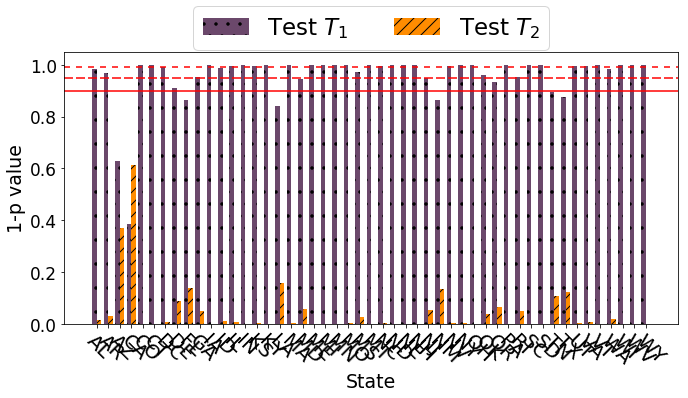

********************************************************************************


In [34]:
print ("State Wise")
Test_and_plot(localize_events_traffic_State,"State","Mean",100,"pack","State-Test-mean")
# Test_and_plot(localize_events_traffic_State,"State","Before",100,"pack","State-Test-before")
#Test_and_plot(localize_events_traffic_State,"State","After",100,"pack","State-Test-after")

Duration Wise
length of keys 159


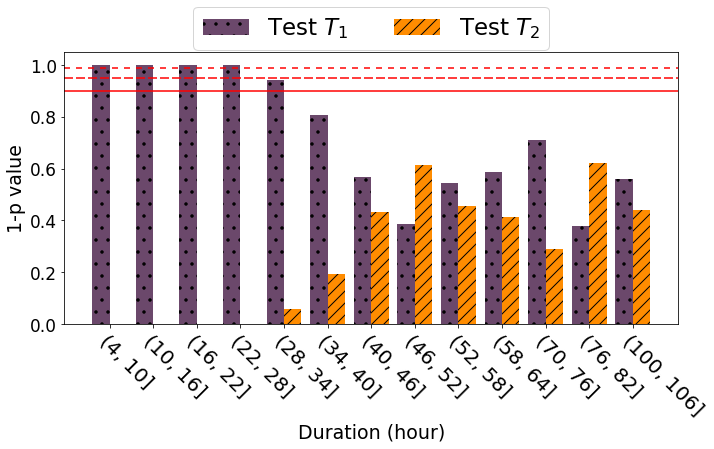

********************************************************************************
length of keys 13


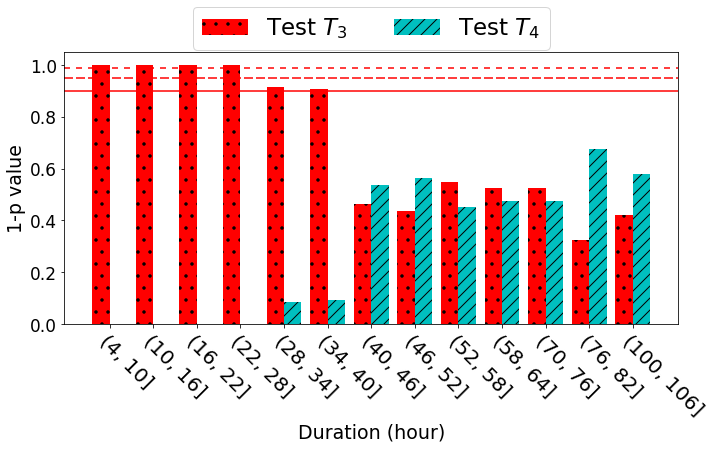

********************************************************************************
length of keys 13


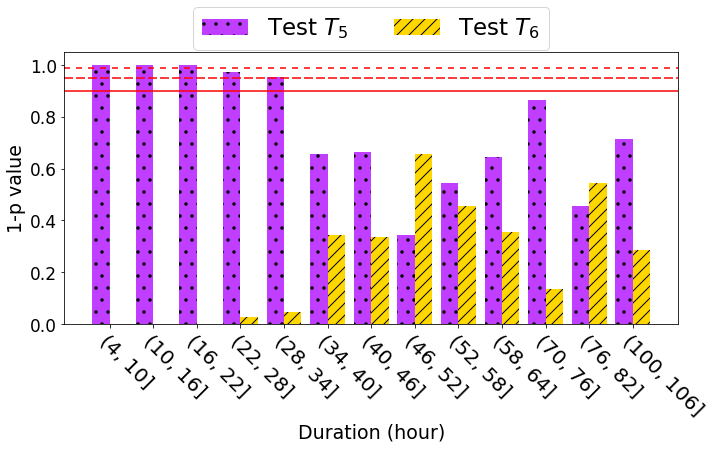

********************************************************************************


In [51]:
print ("Duration Wise")
Test_and_plot(localize_events_traffic_Duration,"Duration (hour)","Mean",200,"pack","Dur-mean")
Test_and_plot(localize_events_traffic_Duration,"Duration (hour)","Before",200,"pack","Dur-before")
Test_and_plot(localize_events_traffic_Duration,"Duration (hour)","After",200,"pack","Dur-after")


Type Wise
length of keys 195


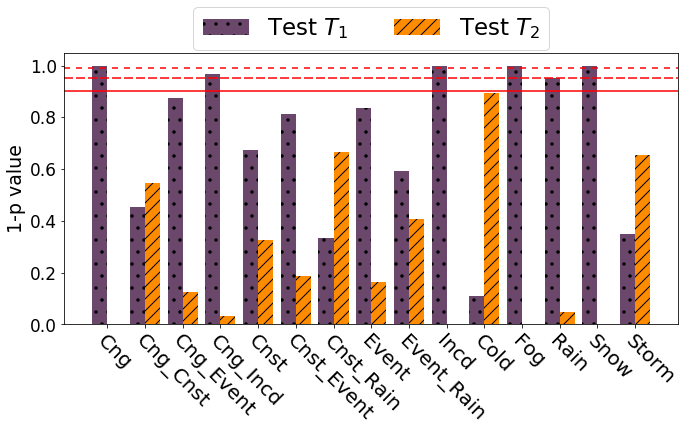

********************************************************************************
length of keys 15


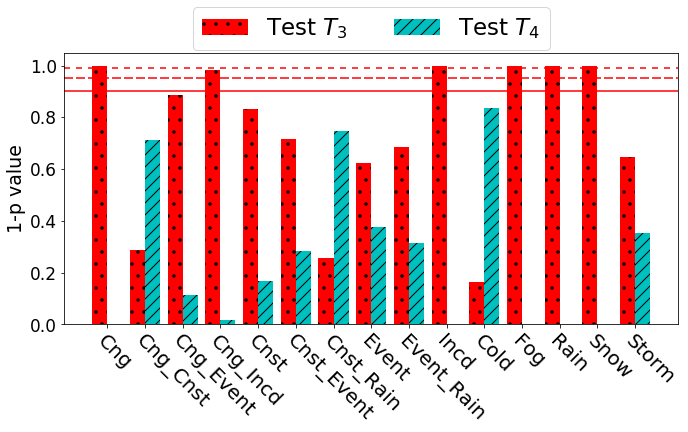

********************************************************************************
length of keys 15


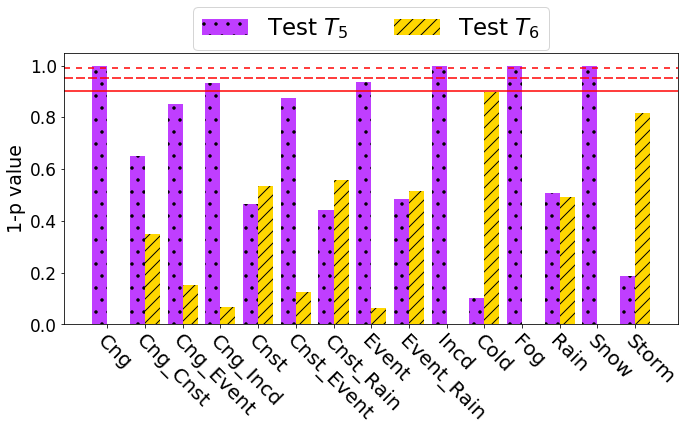

********************************************************************************


In [52]:
print ("Type Wise")
Test_and_plot(localize_events_traffic_Type,"Type","Mean",350,"pack","type-mean")
Test_and_plot(localize_events_traffic_Type,"Type","Before",350,"pack","type-before")
Test_and_plot(localize_events_traffic_Type,"Type","After",350,"pack","type-after")
